In [ ]:
### using python 3.10.5

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency


In [ ]:
### import the data
# there are no headers in the file so they will be imported separately and then appended to the train/test data
# get columns before importing data so we can assign the column headers at import, you can either extract from the txt file or copy it over
# we need to remove the columns containing '| instance weight' according to the instructions and add a column header for the target variable

headers = ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat',
           'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment',
           'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence',
           'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', '| instance weight', 'instance weight',
           'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt',
           'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship',
           'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'weeks worked in year', 'year']
headers.remove('| instance weight')
headers.append('target') # the final column is the target variable

continuous_data = ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']

path_train = r"C:\Users\wausa\Downloads\drive-download-20250220T200642Z-001\census_income_learn.csv"


In [ ]:
# df = pd.read_csv(path_train, names=headers)

df.describe()

,age,detailed industry recode,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year,target
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,-0.134446,-0.060947,-0.104827,-0.060261,1740.380269,0.755334,0.175438,1.514833,23.174897,94.499672,0.062058
std,22.310895,18.067129,0.382961,0.225632,0.304645,0.231729,993.768156,0.807528,0.553694,0.851473,24.411488,0.500001,0.241261
min,0.000000,0.000000,-0.225182,-0.097108,-0.147614,-0.104864,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000,0.000000
25%,15.000000,0.000000,-0.225182,-0.097108,-0.147614,-0.104864,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000,0.000000
50%,33.000000,0.000000,-0.225182,-0.097108,-0.147614,-0.104864,1618.310000,0.693147,0.000000,2.000000,8.000000,94.000000,0.000000
75%,50.000000,33.000000,-0.225182,-0.097108,-0.147614,-0.104864,2188.610000,1.609438,0.000000,2.000000,52.000000,95.000000,0.000000
max,90.000000,51.000000,3.615560,3.099870,2.879785,3.937674,18656.300000,1.945910,2.000000,2.000000,52.000000,95.000000,1.000000


In [ ]:
df = pd.read_csv(path_train, names=headers)

# number of missing datapoints for each feature 
df.isnull().sum().value_counts() # shown as zero but looking at the data we have a number of missing records marked as '?' or have zero values so we 
# will replace the '?' values with NaN. We can also just count the number of '?' values but it is helpful to make the values NaN for encoding later

# data is full of whitespaces so they will be removed
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

df = df.replace('?', np.NaN) # we can see now that the empty values are now accounted for. We could do the same for the columns
# that have '0' as value but perhaps those zeroes are useful records and indicative of actual values such as when 'wage per hour' is zero, it 
# is due to uneployment


In [ ]:
# the target column has been split into two columns (value +50,000 or -50,000), 
# we can avoid this by just converting the value to 1 or 0 in the column. The column is a string so we can just use the string value as the condition

df['target'] = df['target'].apply(lambda x: 0 if x == '- 50000.' else 1)
df['target'].value_counts()

# imbalance in the target classes so we need to consider using some alternative method of evaluating the results aside from the 
# standard confusion matrix

# it may be pertinent to separate the data into numerical and categorical variables to determine the correlations between variables as 
# from the metadata we can see what variables are continues and which are nominal (outlined at the top of the file)

df_continuous = df[continuous_data] # 7 continuous features
df_categorical = df.drop(continuous_data, axis=1) # 35 categorical features
df_categorical = df_categorical.astype('category')


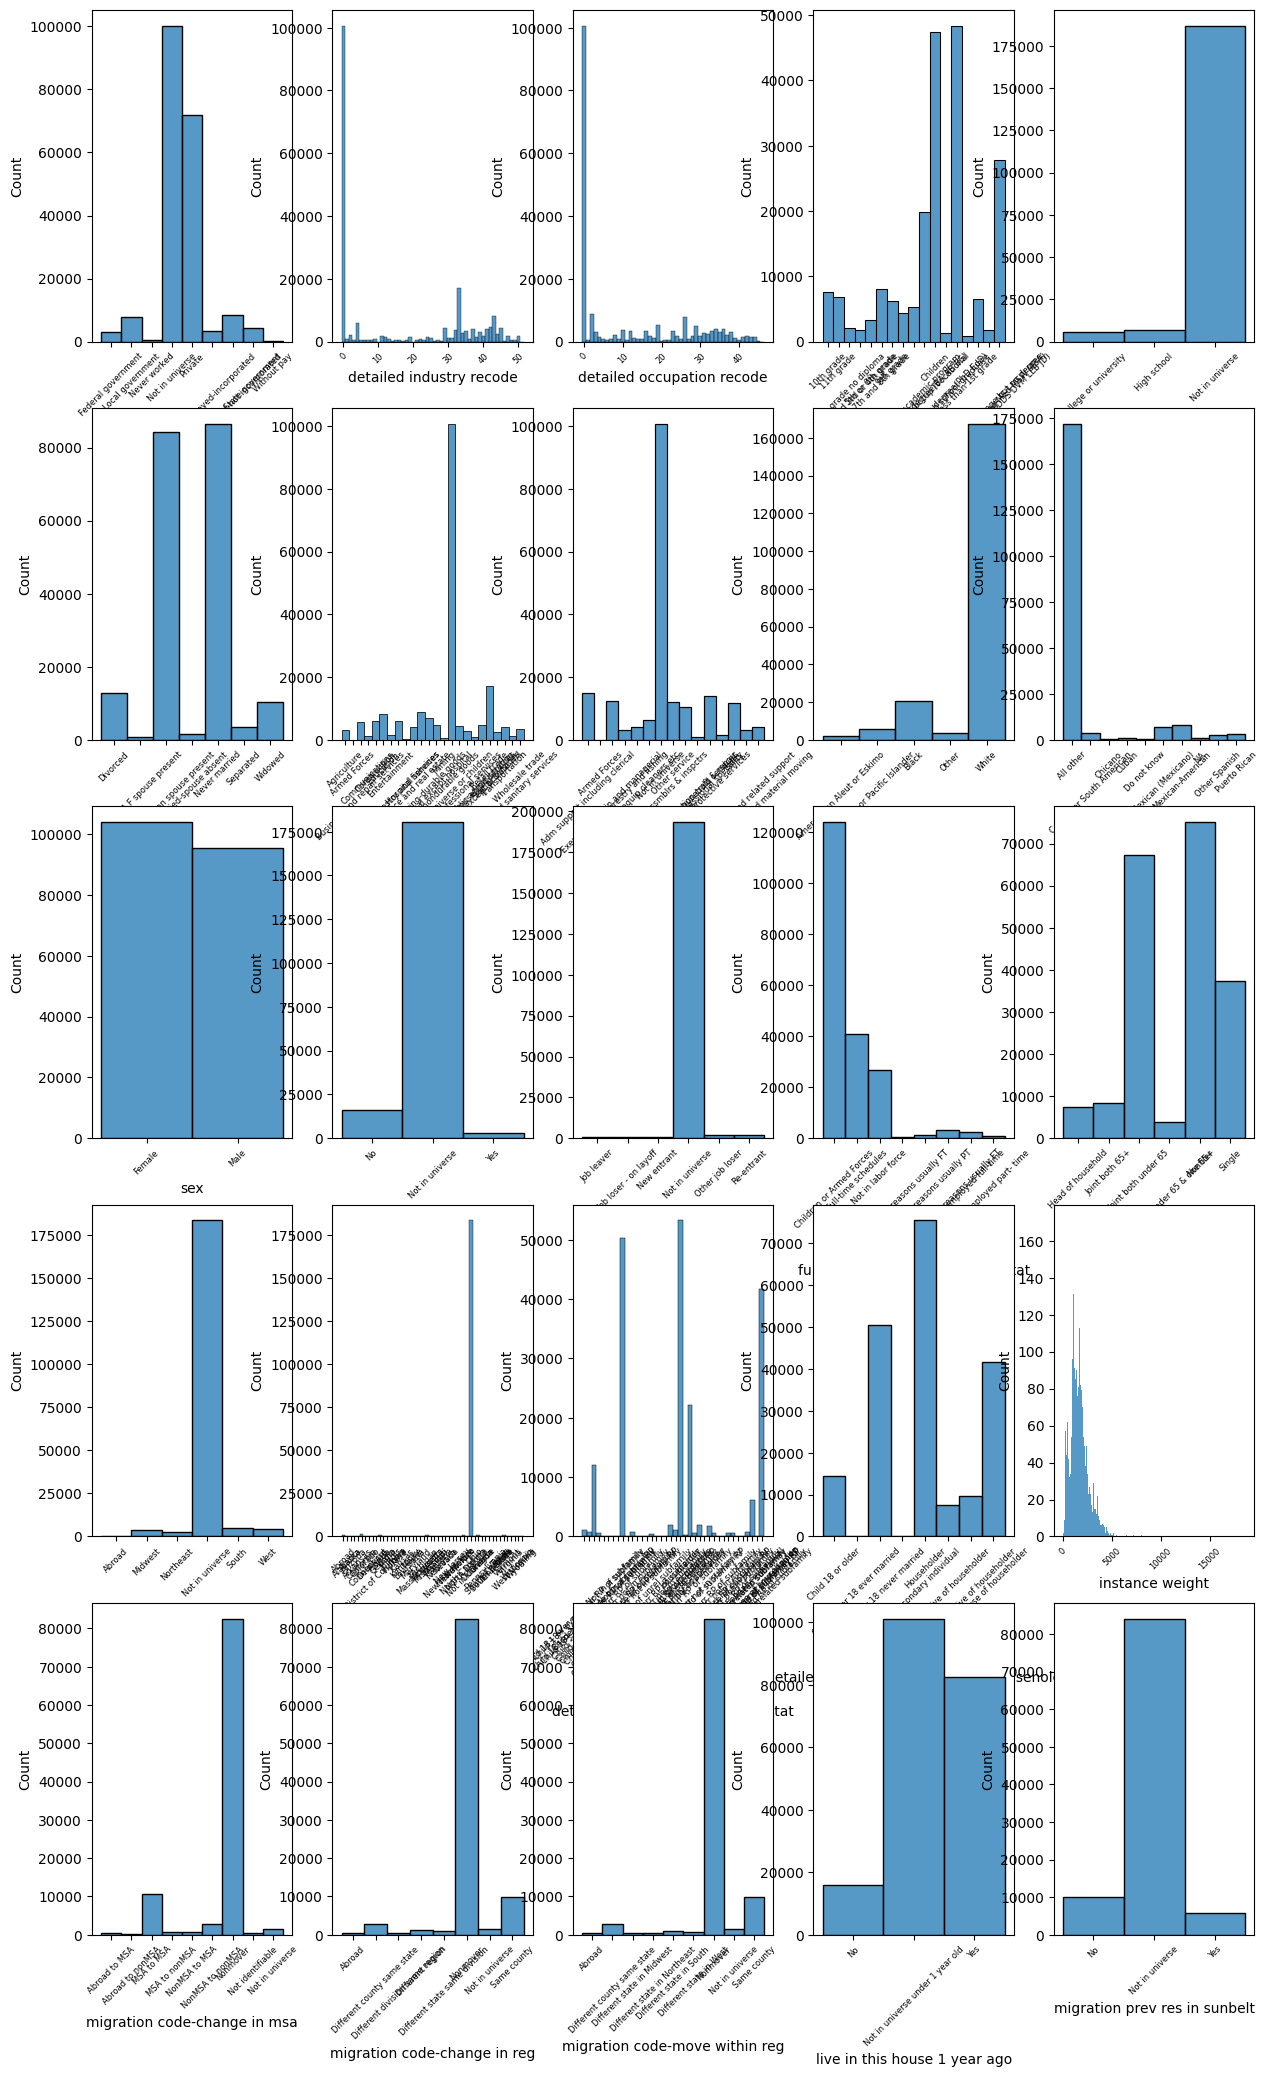

In [ ]:
# there are 35 categorical features, which is high and will get higher if we use one hot encoding for example when we need to process the data
# we can visualise the data

fig, ax = plt.subplots(5, 5)
ax = ax.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 25)

for ax, col in zip(ax, df_categorical.columns):
  sns.histplot(df_categorical[col], ax = ax,)
  ax.tick_params(axis='x', labelrotation=45, labelsize=6)


In [ ]:
# there's a lot of categorical variables, again, we can use correlation to determine if we can reduce the feature count
# we can use the chi2_contingency function in scipy
# our categorical values are not nominal so there's no ordering to maintain

# we can view this correlation using Cramers V test, which is used to calcualte the correlation between categorical values, in this 
# example, those which are nominal

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt((phi2corr / min( (kcorr-1), (rcorr-1))))

contingency = pd.crosstab(df_categorical['region of previous residence'], df_categorical['state of previous residence']).values
cramers = cramers_v(contingency)
print(cramers)


0.9758500164416093


<AxesSubplot:>

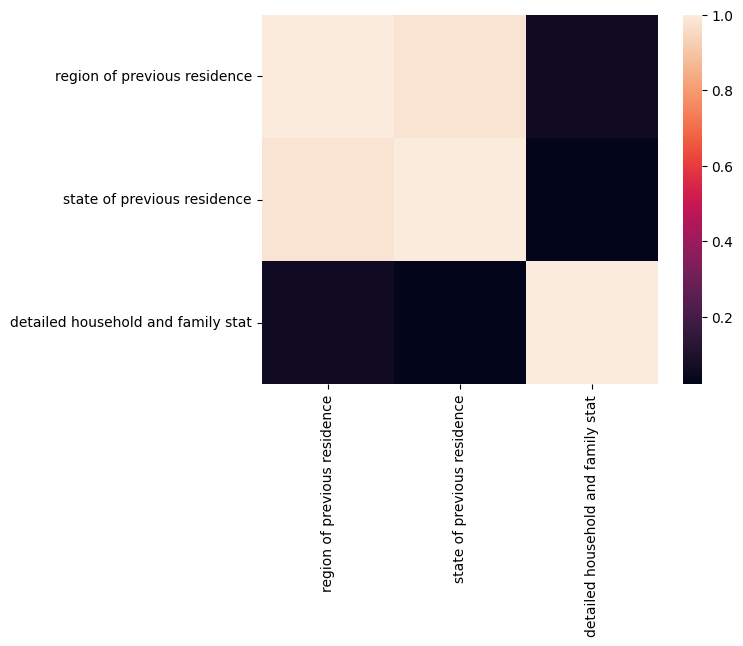

In [ ]:
df_categorical_first15 = df_categorical.iloc[:, 0:15] # first 15 features, not enough memory to compare them all

df_categorical_20_to_35 = df_categorical.iloc[:, 20:35] # some memory issues in one of the columns between 15-20, 
# could potentially explore why given more time

rows= []
for var1 in df_categorical_20_to_35:
    col = []
    for var2 in df_categorical_20_to_35 :
        contingency = pd.crosstab(df_categorical_20_to_35[var1], df_categorical_20_to_35[var2]).values
        cramers = cramers_v(contingency)
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
cramers_df = pd.DataFrame(cramers_results, columns = df_categorical_20_to_35.columns, index =df_categorical_20_to_35.columns)

sns.heatmap(cramers_df)

In [ ]:
# we can drop the highly correlated fields to reduce the number of features
# i.e., detailed industry recode and detailed occupation recode, major industry code and major occupation code, 
# detailed household and family stat and detailed household summary in household
# migration code-change in msa, migration code-change in reg, migration code-move within reg, migration prev res in sunbelt
# fill inc questionnaire for veteran\'s admin and veterans benefits

corr_cols_to_remove = ['detailed occupation recode', 'major occupation code', 'detailed household summary in household', 'migration code-change in msa', 
                     'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt', 'fill inc questionnaire for veteran\'s admin', 
                     'region of previous residence']

df = df.drop(corr_cols_to_remove, axis=1) # remove columns from original df

df_categorical = df_categorical.drop(corr_cols_to_remove, axis=1)


<AxesSubplot:>

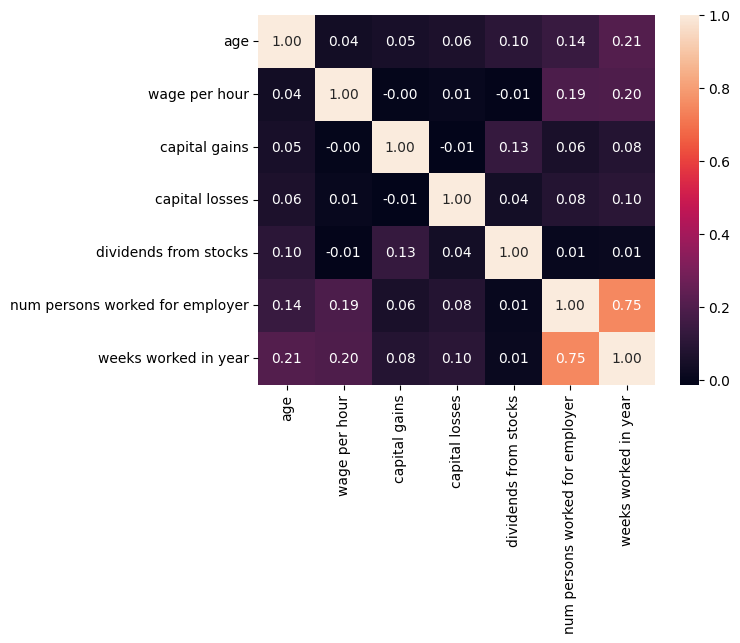

In [ ]:
# for numerical values we can immediately view the correlation as a heatmap

sns.heatmap(df_continuous.corr(), annot=True, fmt='.2f')

# we can see the numerical values are not necessarily correlated aside from 'number of persons worked for employer'/'weeks worked' 
# which has a fairly strong correlation at 0.75. We will keep all columns as the correlation is not that extreme

# we could also use a different statistical test to compare correlations between the continuous and nominal values but I'm not familiar with them


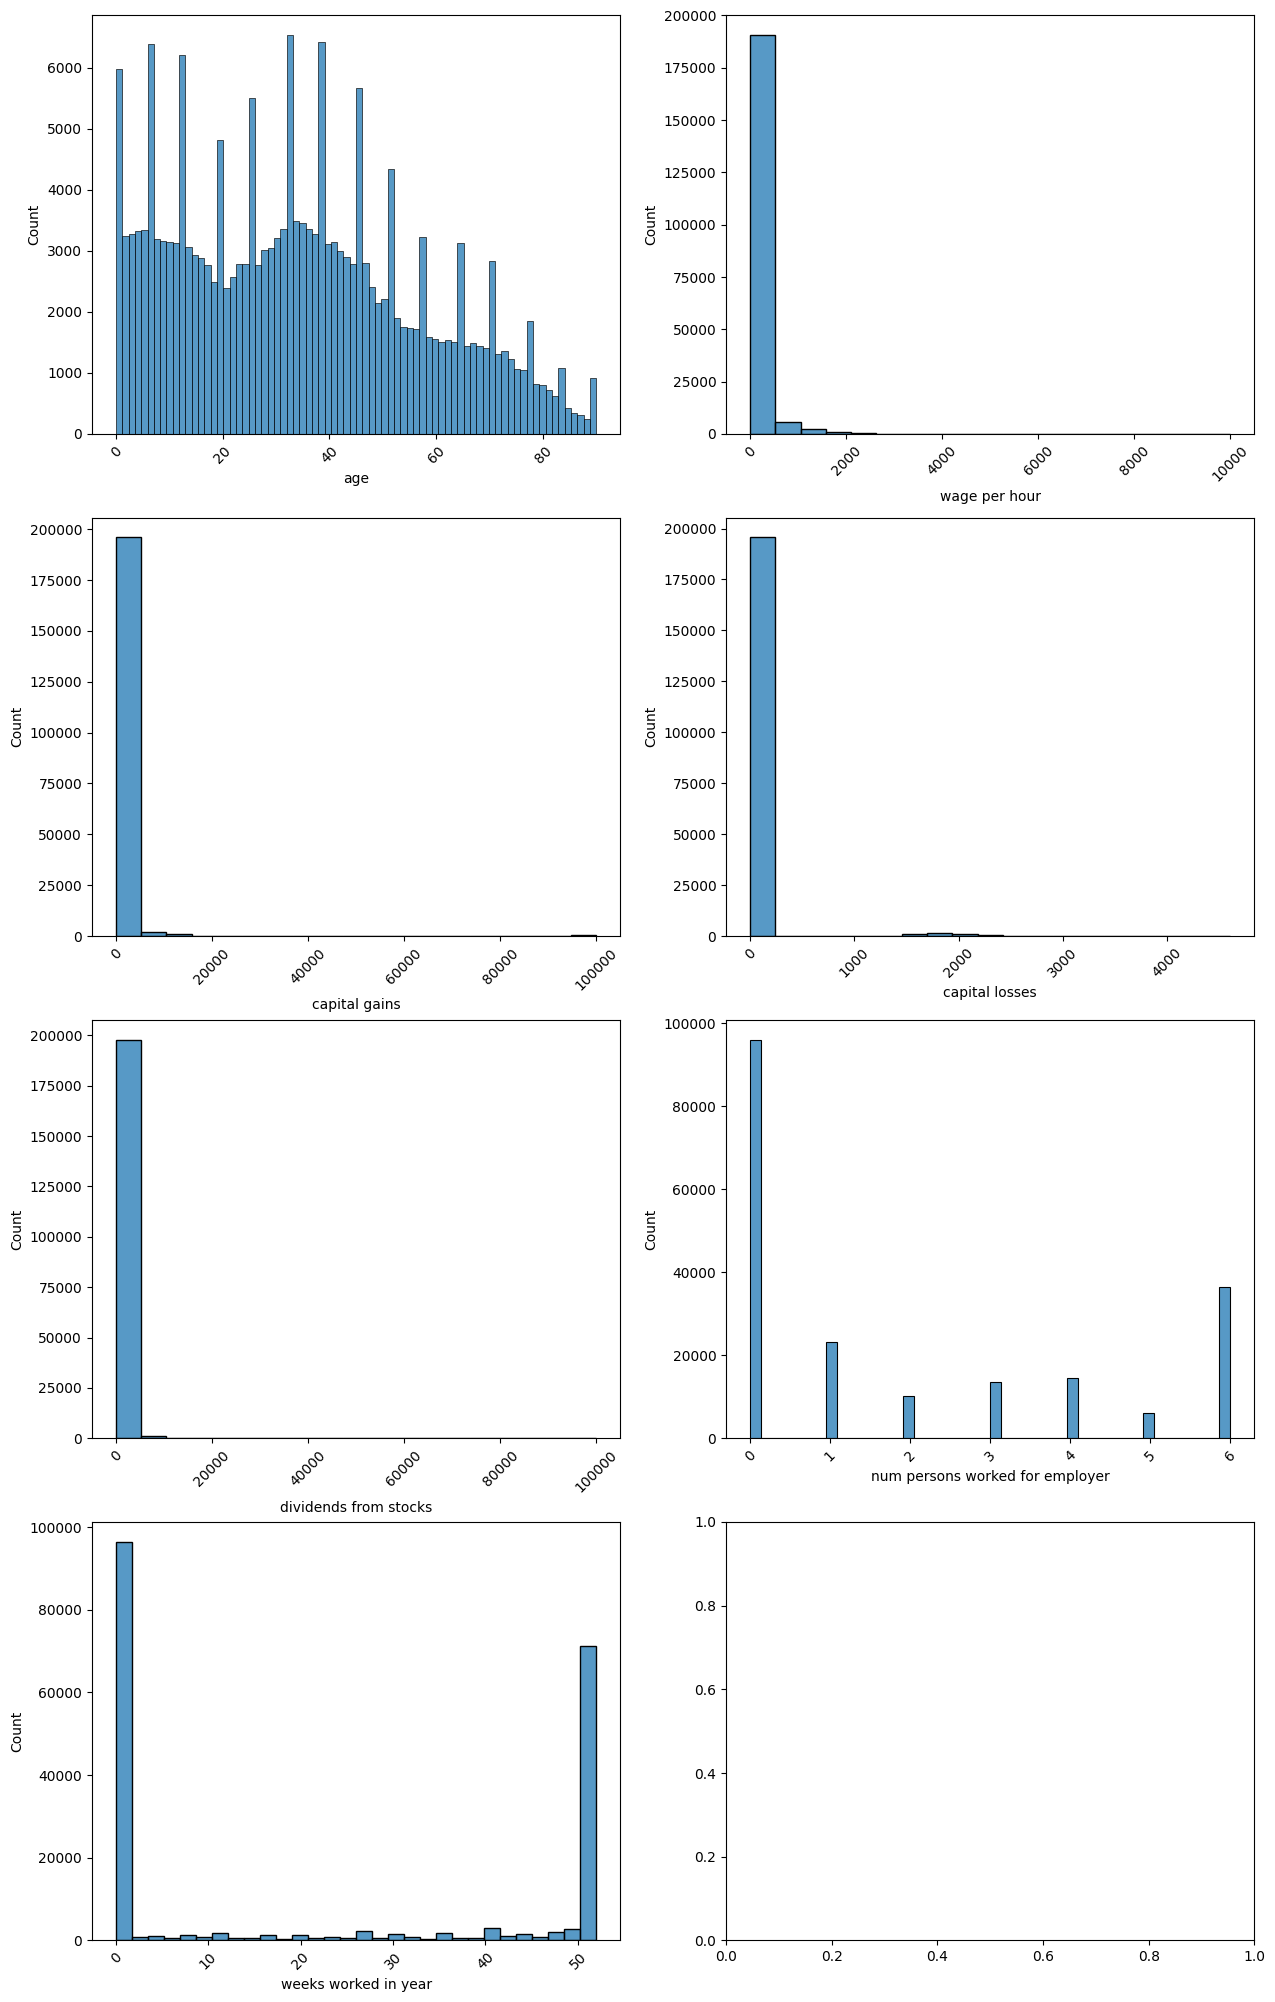

In [ ]:
# we may consider scaling the continuous values if the range is high and we can also transform the same data if there's a high skew >0.5 or <-0.5

# we can view the caegorical values
fig, ax = plt.subplots(4, 2)
ax = ax.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 25)

for ax, col in zip(ax, df_continuous.columns):
  sns.histplot(df_continuous[col], ax = ax,)
  ax.tick_params(axis='x', labelrotation=45)

<AxesSubplot:>

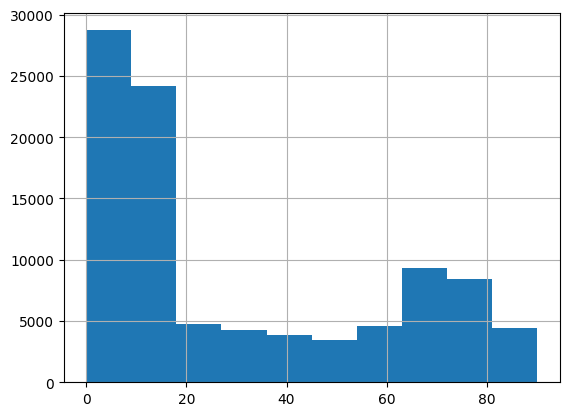

In [ ]:
# We can see a lot of zero values here which provides a large amount of skew for this data, however given the nature of the data 
# it doesn't necessarily make sense to remove the data, rather it provides information about people who may be unemployed or have no investments

# for example, most of those not working are either young (<20) or old/retired (> 60) as shown below
df.loc[df['weeks worked in year'] == 0 , 'age'].hist()

In [ ]:
# we can still look at the skew and kurotsis of these continuous variables
# skew above 0.5 or below -0.5 is generally significant and for Kurtosis values above 2 or below -2 

for x in df_continuous.columns:
    print(f'The skew of the variable {x} is: {skew(df[x])}')
    print(f'The kurtosis of the variable {x} is: {kurtosis(df[x])}')

# we may consider applying a log transformation to reduce the skew.
# we may also want to scale 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks' as they have large value ranges

scaler = StandardScaler() # scale specific columns -> skew is unchanged

for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']:
    df[col] = scaler.fit_transform(df[[col]])

# now log transform the highly skewed columns 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer'

for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer']:
    df[col] = np.log(df[[col]] + 1) # we need to add the 1 to the values as we cannot log transform the 0 values
    # df[col] = np.sqrt(df[[col]] + 1) # culd sqrt transform instead, again, we need to add the 1 to the values as we cannot sqrt transform the 0 values

# just looking at skew, skews are still large due to the large number of zeroes, but they are reduced
for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']:
    print(f'\nThe transformed skew of the variable {col} is: {skew(df[col])}')



The skew of the variable age is: 0.3732876509407539
The kurtosis of the variable age is: -0.7328360081718905
The skew of the variable wage per hour is: 8.935029357488652
The kurtosis of the variable wage per hour is: 155.21497713655918
The skew of the variable capital gains is: 18.990679572017093
The kurtosis of the variable capital gains is: 393.05295239438146
The skew of the variable capital losses is: 7.632507318715383
The kurtosis of the variable capital losses is: 61.631358480130274
The skew of the variable dividends from stocks is: 27.78629289133186
The kurtosis of the variable dividends from stocks is: 1090.5363947309827
The skew of the variable num persons worked for employer is: 0.7515550301653675
The kurtosis of the variable num persons worked for employer is: -1.082249783982674
The skew of the variable weeks worked in year is: 0.21016776188361566
The kurtosis of the variable weeks worked in year is: -1.863789191403568

The transformed skew of the variable wage per hour is: 4

In [ ]:
# consider ml
# pd.get_dummies(data=df, columns=[col for col in df.columns if col not in df_categorical.columns])

# convert columns to categories again?

# df.info()
# df_dummies = pd.get_dummies(df) # one hot encoding of categorical columns
# pd.get_dummies(df[['age', 'class of worker', 'education', 'year']])
pd.get_dummies(df)

# one hot encoding produces 300+ features which is too many so it will be avoided
# consider a model that does not need encoded features ?
# scikit learn needs one hot encoded categories so it will be avoided


In [ ]:
# need to transform for testing data as it is included as a separate file
# we could just append the two files together and add a separate column for identifying as test/train data, but we will keep the data 
# separately for the moment 

df_test = pd.read_csv(r"C:\Users\wausa\Downloads\drive-download-20250220T200642Z-001\census_income_test.csv", names=headers)
df_test = df_test.drop(corr_cols_to_remove, axis=1) # remove columns from original df

# scale and transform as above
for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']:
    df_test[col] = scaler.fit_transform(df_test[[col]])

for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer']:
    df_test[col] = np.log(df_test[[col]] + 1)


In [ ]:
df_test.info() # 2/3:1/3 train:test split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 99762 non-null  int64  
 1   class of worker                     99762 non-null  object 
 2   detailed industry recode            99762 non-null  int64  
 3   education                           99762 non-null  object 
 4   wage per hour                       99762 non-null  float64
 5   enroll in edu inst last wk          99762 non-null  object 
 6   marital stat                        99762 non-null  object 
 7   major industry code                 99762 non-null  object 
 8   race                                99762 non-null  object 
 9   hispanic origin                     99762 non-null  object 
 10  sex                                 99762 non-null  object 
 11  member of a labor union             99762

In [ ]:
# from sklearn.model_selection import train_test_split # data is already split so may not need

# transform object data to categorical data for the original dataframe and the test dataframe
for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

for col in df_test.select_dtypes(include=['object']).columns:
        df_test[col] = df_test[col].astype('category')

# assign test and train data
X_train, y_train = df.iloc[:, :-1], df.iloc[:, -1]
X_test, y_test  = df_test.iloc[:, :-1], df_test.iloc[:, -1]


In [ ]:
from xgboost import XGBRegressor

In [ ]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, enable_categorical=True, verbose=False,)

TypeError: XGBModel.fit() got an unexpected keyword argument 'enable_categorical'

In [ ]:
predictions = my_model.predict(X_test)
